In [1]:
# In Class Lab 6
# Surface Brightness Profiles


In [2]:
# Load Modules
import numpy as np
import astropy.units as u

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from GalaxyMass import ComponentMass

# Lab 6: Sersic Profiles

In this lab we will use Homework 5 solutions to compute the mass profile of M31's bulge. 

We will turn the mass profile into a density profile and see if we can fit it reasonably well with a sersic profile. 

# Part A

Determine the Surface Mass Density Profile for the Simulated M31 bulge

a) find the positions and masses of all the bulge particles

In [3]:
# Create a center of mass object for M31
# I.e. an instance of the CenterOfMass class 

# bulge particles (ptype=3)
M31_COM = CenterOfMass("M31_000.txt", 3)

In [4]:
# COM of M31
M31_COM_p = M31_COM.COM_P(0.1)

In [5]:
# Use the center of mass object to 
# store the x, y, z, positions and mass of the bulge particles
# be sure to correct for the COM position of M31
x = M31_COM.x - M31_COM_p[0].value
y = M31_COM.y - M31_COM_p[1].value
z = M31_COM.z - M31_COM_p[2].value
m = M31_COM.m # 1e10 Msun

b) Change the bulge particle positions into cylindrical coordinates

In [6]:
# Determine the positions of the bulge particles in 
# cylindrical coordinates. 

cyl_r = np.sqrt(x**2 + y**2) # r
cyl_theta = np.arctan2(y, x) # theta

c) determine the projected surface mass density profile

In [7]:
def SurfaceDensity(r,m):
    """ Function that computes the surface mass density profile
    given an array of particle masses and radii 
     
    PARMETERS
    ---------
        r : array of `floats` - cyclindrical radius [kpc]
        m : array of `floats` - particle masses [1e10 Msun] 
    
    RETURNS
    -------
        r_annuli : array of `floats` -  radial bins for the 
            annuli that correspond to the surface mass density profile
    
        sigma: array of `floats` - surface mass density profile 
         [1e10 Msun/kpc^2] 
        
        
    """
    
    # Create an array of radii that captures the extent of the bulge
    # 95% of max range of bulge
    radii = np.arange(0.1, 0.95 * r.max(), 0.1)

    # create a mask to select particles within each radius
    # np.newaxis creates a virtual axis to make cyl_r_mag 2 dimensional
    # so that all radii can be compared simultaneously
    # a way of avoiding a loop - returns a boolean 
    enc_mask = r[:, np.newaxis] < radii

    # calculate mass of bulge particles within each annulus.  
    # relevant particles will be selected by enc_mask (i.e., *1)
    # outer particles will be ignored (i.e., *0)
    # axis =0 flattens to 1D
    m_enc = np.sum(m[:, np.newaxis] * enc_mask, axis=0)

    # use the difference between m_enc at adjacent radii 
    # to get mass in each annulus
    m_annuli = np.diff(m_enc) # one element less then m_enc
    
    
    # Surface mass density of stars in the annulus
    # mass in annulus / surface area of the annulus. 
    # This is in units of 1e10
    sigma = m_annuli / (np.pi * (radii[1:]**2 - radii[:-1]**2))
    # array starts at 0, but here starting at 1 and
    # subtracting radius that ends one index earlier.
    
    # Define the range of annuli
    # here we choose the geometric mean between adjacent radii
    r_annuli = np.sqrt(radii[1:] * radii[:-1]) 

    return r_annuli, sigma


In [8]:
# Define the surface mass density profile for the simulated bulge
# and the corresponding annuli

r_annuli, sigmaM31_bulge = SurfaceDensity(cyl_r, m)

# Part B 



a) Create a function called `sersicE` that returns the Sersic Profile in terms of the effective radius $R_e$ (i.e. the half light radius).

$I(r) = I_e exp^{-7.67 ( (r/R_e)^{1/n} - 1)}$

Where 

$ L = 7.2 I_e \pi R_e^2$

and  $R_e$ is the half light radius.  We will assume a mass to light ratio for the stellar bulge of 1, so this is also the half mass radius.

The function should take as input the radius, $R_e$, $n$ and the total stellar mass of the system.


In [9]:
def sersicE(r, re, n, mtot):
    """ Function that computes the Sersic Profile for an Elliptical 
    System, assuming M/L ~ 1. As such, this function is also the 
    mass surface density profile. 
    
    PARMETERS
    ---------
        r: `float`
            Distance from the center of the galaxy (kpc)
        re: `float`
            The Effective radius (2D radius that contains 
            half the light) (kpc)
        n:  `float`
            sersic index
        mtot: `float`
            the total stellar mass (Msun)

    RETURNS
    -------
        I: `array of floats`
            the surface brightness/mass density
            profile for an elliptical in Lsun/kpc^2

    """
    # M/L = 1
    lum = mtot 

    # the effective surface brightness
    Ie = lum/7.2/np.pi/re**2

    # break down sersic profile
    a = (r/re)**(1/n)
    b = -7.67*(a-1)
    
    # the surface brightness or mass density
    I = Ie*np.exp(b)
    
    return I

b) Compute the M31 Bulge Mass Profile using Homework 5 MassProfile


In [10]:
# Create a mass profile object for M31
# using solution to Homework 5
M31mass = MassProfile("M31", 0)

In [18]:
# Determine the Bulge mass profile
# use the annuli defined for the surface mass density profile
bulge_mass = M31mass.massEnclosed(3, r_annuli)

c) Determine the effective radius of the bulge. Compute the total mass using Component Mass, from the GalaxyMass code, and find the radius that contains half this mass. 

In [11]:
# Determine the total mass of the bulge
bulge_total = ComponentMass('M31_000.txt', 3)*1e12
print(f'{bulge_total:.2e}')

1.90e+10


In [13]:
# Find the effective radius of the bulge, 
# Re encloses half of the total bulge mass

# Half the total bulge mass
b_half = bulge_total/2.0
print(f'{b_half:.2e}')

9.50e+09


In [ ]:
# Find the indices where the bulge mass is larger than b_half
idx = np.where(bulge_mass > b_half*u.Msun)

# take first index where Bulge Mass > b_half
# check : should match b_half
print(f'{bulge_mass[idx][0]:.2e}')

9.53e+09 solMass


In [32]:
# Define the Effective radius of the bulge
re_bulge = r_annuli[idx][0]
print(re_bulge)

2.5495097567963927


d) Define the Sersic Profile for the M31 Bulge

In [30]:
# Sersic Index = 4
sersicM31_bulge = sersicE(r_annuli, re_bulge, 4, bulge_total)

# Part D

a) Plot the simulated surface mass density profile of M31's bulge as a proxy for its surface brightness profile (M/L = 1) 

b) Plot the M31 Bulge Sersic Profile


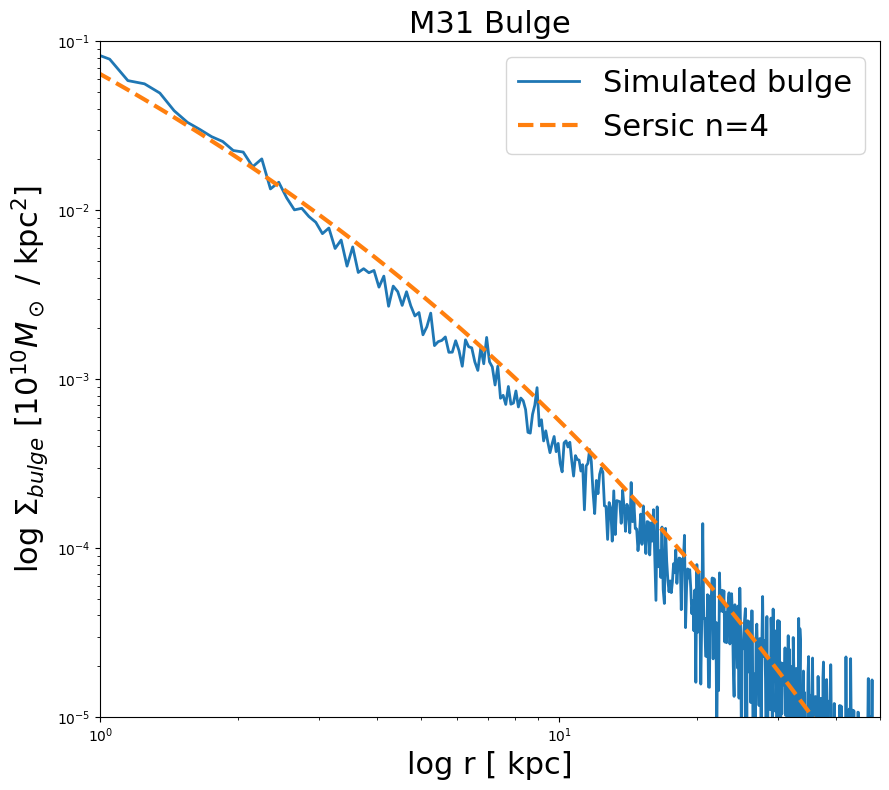

In [31]:
fig, ax = plt.subplots(figsize=(9, 8))

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# Surface Density Profile
# YOU ADD HERE
ax.loglog(r_annuli, sigmaM31_bulge, lw=2, label='Simulated bulge')

# Sersic fit to the surface brightness Sersic fit
# YOU ADD HERE
ax.loglog(r_annuli, sersicM31_bulge/1e10, lw=3, linestyle='--',
          label='Sersic n=4')


plt.xlabel('log r [ kpc]', fontsize=22)

# note the y axis units
plt.ylabel(r'log $\Sigma_{bulge}$ [$10^{10} M_\odot$ / kpc$^2$]', 
          fontsize=22)

plt.title('M31 Bulge', fontsize=22)

#set axis limits
plt.xlim(1,50)
plt.ylim(1e-5,0.1)

ax.legend(loc='best', fontsize=22)
fig.tight_layout()

#plt.savefig('Lab6.png')